In [1]:
# %%

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt
import pandas as pd
import scipy
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

#This is the .mat file as data frame.
__mat_data__ = scipy.io.loadmat('Xtrain.mat')
    # Convert to DataFrame, there is only one variable in the .mat file
df = pd.DataFrame(__mat_data__['Xtrain']) 

# %% [markdown]

 ## Data Inspection
 We will inspect the data to understand its structure and characteristics in the Xtrain.mat file.
 It contains a single variable, which appears to be sequential data, like a time series.
 See the visualization of the data below:

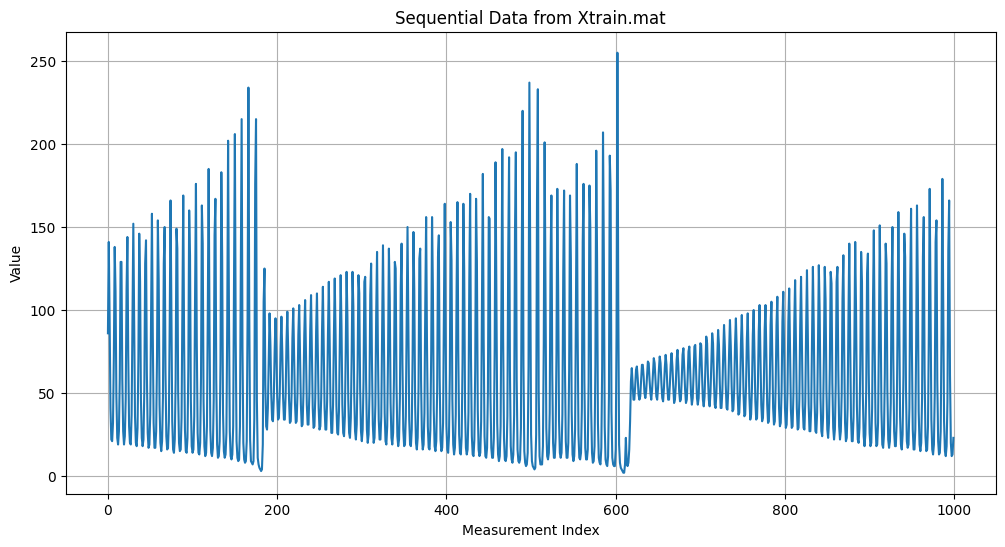

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(df[0])
plt.title('Sequential Data from Xtrain.mat')
plt.xlabel('Measurement Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

# %% [markdown]

 Check the data for stationarity, which has a stable mean and variance over time.
 It is important to have stationary data to predict the next value.
 Below is a visualisation of the rolling mean and standard deviation.

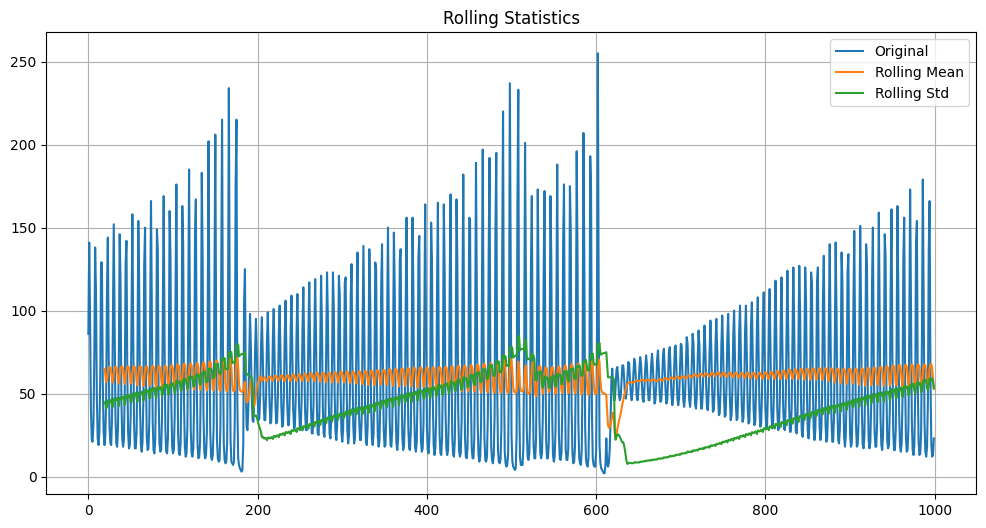

In [4]:
window_size = 20
rolling_mean = df[0].rolling(window=window_size).mean()
rolling_std = df[0].rolling(window=window_size).std()

plt.figure(figsize=(12, 6))
plt.plot(df[0], label='Original')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std')
plt.legend()
plt.title('Rolling Statistics')
plt.grid(True)
plt.show()

# window_size = 7
# rolling_mean = df[0].rolling(window=window_size).mean()
# rolling_std = df[0].rolling(window=window_size).std()

# plt.figure(figsize=(12, 6))
# plt.plot(df[0], label='Original')
# plt.plot(rolling_mean, label='Rolling Mean')
# plt.plot(rolling_std, label='Rolling Std')
# plt.legend()
# plt.title('Rolling Statistics')
# plt.grid(True)
# plt.show()

# %% [markdown]

 Based on the observations, the data appears to be stationary around the mean, but the variance seems to fluctuate.
 Let's perform statistical tests to confirm the stationarity of the data.
 The Augmented Dickey-Fuller (ADF) test and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test are commonly used for this purpose.

In [5]:
# %%

from statsmodels.tsa.stattools import adfuller, kpss

adf_p = adfuller(df[0])[1]
adf_p = round(adf_p, 4)
# ADF Test (null hypothesis: time series is non-stationary)
# If p-value < 0.05, we reject the null hypothesis (data is stationary)
if adf_p < 0.05:
    print(f"ADF test: The data is stationary (p-value = {adf_p:>.3} < 0.05)")
else:
    print(f"ADF test: The data is non-stationary (p-value = {adf_p} >= 0.05)")
    
# KPSS test (null hypothesis: time series is stationary)
# If p-value < 0.05, we reject the null hypothesis (data is non-stationary)
kpss_p = kpss(df[0])[1]
kpss_p = round(kpss_p, 4)
if kpss_p < 0.05:
    print(f"KPSS test: The data is non-stationary (p-value={kpss_p} < 0.05)")
else:
    print(f"KPSS test: The data is stationary (p-value={kpss_p} >= 0.05)")

ADF test: The data is stationary (p-value = 0.0 < 0.05)
KPSS test: The data is stationary (p-value=0.1 >= 0.05)


/var/folders/lm/8m47310n0sbc6d8tdlxcd8pw0000gn/T/ipykernel_16179/3168389424.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p = kpss(df[0])[1]


# %% [markdown]

 Both tests indicate that the data is stationary, so we can proceed with the inspection,
 no need for differencing or transformation.
 ## Lag Order Selection
 In this type of data, the order of the data points is important,
 and each data point carries information about next data points. However, as the data moves forward, the data points
 become less relevant. How many data points should we remember and when to forget depends on the lag order.
 It tells us how many previous data points we should consider to predict the next data point.
 Choosing the right lag order is crucial for the performance of the model.
 We will use 2 methods to evaluate the lag order:
 1. Information Criteria (AIC, BIC, HQIC)
 2. Cross-validation (MSE)
 and compare the results of both methods.

# %% [markdown]

 ### 1. Information Criteria
 We perform auto-regression for each lag order and calculate different loss function for each lag order.
 AIC applies lighter penalty for more parameters than BIC, and HQIC is a compromise between.
 It is common to use AIC if prediction is the goal, BIC is used if a simpler model is desired.

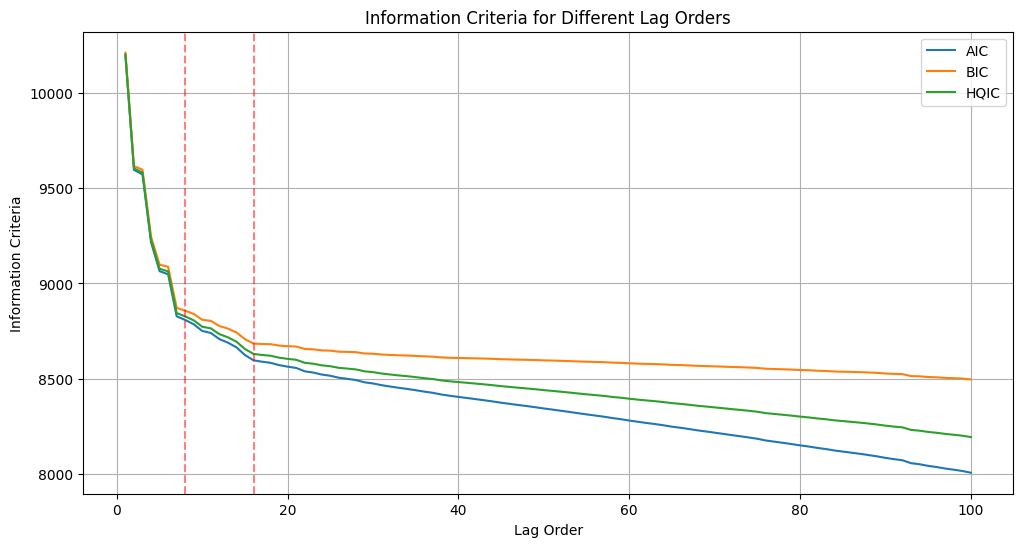

In [ ]:
def evaluate_lag_order(series, max_lag=100):
    # Function to evaluate different lag orders.
    # We picked the trend as 'c' because the data is fluctuating around a stable mean value.
    results = {}
    for lag in range(1, max_lag+1):
        model = AutoReg(series.dropna(), lags=lag, trend='c')
        model_fitted = model.fit()
        results[lag] = {
            'aic': model_fitted.aic,
            'bic': model_fitted.bic,
            'hqic': model_fitted.hqic
        }
    return results

# Evaluate different lag orders
max_lag = 100
lag_evaluation = evaluate_lag_order(df[0], max_lag=max_lag)

# Plot AIC, BIC, HQIC for different lag orders
aics = [lag_evaluation[i]['aic'] for i in range(1, max_lag+1)]
bics = [lag_evaluation[i]['bic'] for i in range(1, max_lag+1)]
hqics = [lag_evaluation[i]['hqic'] for i in range(1, max_lag+1)]
plt.figure(figsize=(12, 6))
plt.plot(range(1, max_lag+1), aics, label='AIC')
plt.plot(range(1, max_lag+1), bics, label='BIC')
plt.plot(range(1, max_lag+1), hqics, label='HQIC')
plt.axvline(x=8, color='r', linestyle='--', alpha=0.5)
plt.axvline(x=16, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Lag Order')
plt.ylabel('Information Criteria')
plt.legend()
plt.title('Information Criteria for Different Lag Orders')
plt.grid(True)
plt.show()

# %% [markdown]

 Based on the visual inspection, it look like lag order 7 and 15 are good candidates.
 ### 2. Cross-validation (MSE)
 We will compare different lag order values by using a simple linear model for prediction
 and compare the MSE loss function.

Best lag order: 7 with MSE: 445.6011


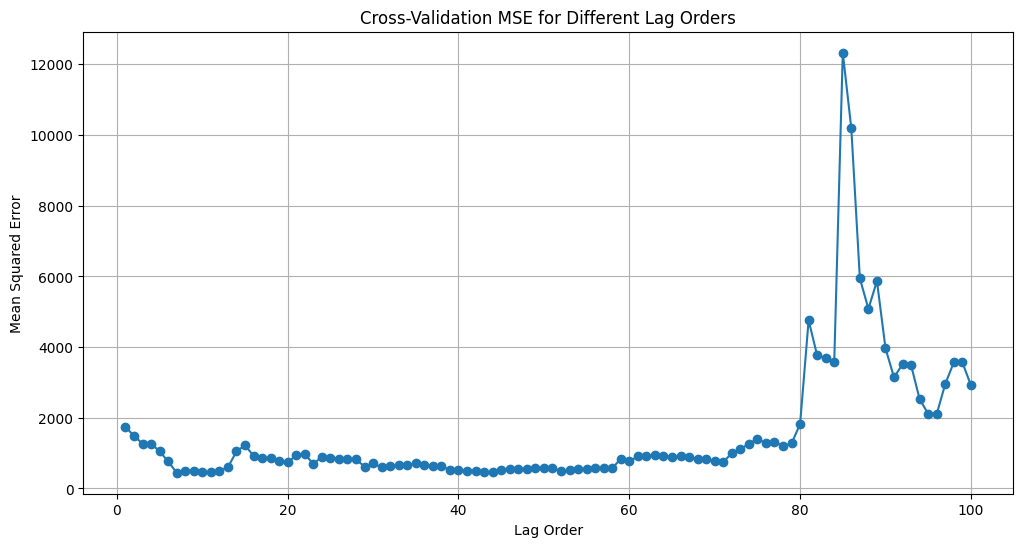

In [ ]:
def time_series_cv(series, max_lag=20, n_splits=10):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    mse_scores = {}
    
    for lag in range(1, max_lag+1):
        mse = []
        for train_idx, test_idx in tscv.split(series):
            train = series.iloc[train_idx]
            test = series.iloc[test_idx]
            
            # Skip if test set is too small for this lag
            if len(test) <= lag:
                continue
            
            # Create lagged features
            X_train = np.array([train.iloc[i-lag:i].values for i in range(lag, len(train))])
            y_train = train.iloc[lag:].values
            
            X_test = np.array([test.iloc[i-lag:i].values for i in range(lag, len(test))])
            y_test = test.iloc[lag:].values
            
            # Simple linear model, Ordinary Least Squares
            model = sm.OLS(y_train, X_train).fit()
            predictions = model.predict(X_test)
            
            mse.append(mean_squared_error(y_test, predictions))
        
        # Only calculate mean if we have values
        if mse:
            mse_scores[lag] = np.mean(mse)
        else:
            # Handle case where no folds were valid for this lag
            mse_scores[lag] = float('nan')  # or some other value
    
    return mse_scores

# Get MSE scores for different lag orders
max_lag = 100
mse_scores = time_series_cv(df[0], max_lag=max_lag, n_splits=5)
# print the min mse score and the corresponding lag order
min_mse = min(mse_scores.values())
best_lag = min(mse_scores, key=mse_scores.get)
print(f"Best lag order: {best_lag} with MSE: {min_mse:.4f}")

# Plot MSE for different lag orders
plt.figure(figsize=(12, 6))
plt.plot(list(mse_scores.keys()), list(mse_scores.values()), marker='o')
plt.xlabel('Lag Order')
plt.ylabel('Mean Squared Error')
plt.title('Cross-Validation MSE for Different Lag Orders')
plt.grid(True)
plt.show()